<a href="https://colab.research.google.com/github/xinyanLyu/recommendation/blob/master/HW7_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Recommendation system 
*reference https://www.kaggle.com/laowingkin/netflix-movie-recommendation

#Install

In [0]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.metrics.pairwise import cosine_similarity
import operator
%matplotlib inline
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [0]:
!pip install -q scikit-surprise

In [0]:
from surprise import Reader, Dataset, SVD, evaluate
from surprise.model_selection import cross_validate

#Mount GDrive and Import Data

###Mount GDrive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import os;os.listdir("/content/gdrive/My Drive/machine_learning/anime_recommendation")

Mounted at /content/gdrive


['anime.csv', 'rating.csv']

###Import data

In [0]:
# import data

anime = pd.read_csv("/content/gdrive/My Drive/machine_learning/anime_recommendation/anime.csv")
ratings  = pd.read_csv("/content/gdrive/My Drive/machine_learning/anime_recommendation/rating.csv")

#Ingestion

In [0]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [0]:
ratings.head(10)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
5,1,355,-1
6,1,356,-1
7,1,442,-1
8,1,487,-1
9,1,846,-1


In [0]:
 #ratings dataset uses a "-1" to represent missing ratings
 #convert them into NaN
ratings.rating.replace({-1: np.nan}, regex=True, inplace = True)
ratings.head()


,user_id,anime_id,rating
0,1,20,NaN
1,1,24,NaN
2,1,79,NaN
3,1,226,NaN
4,1,241,NaN


In [0]:
print('Full dataset shape: {}'.format(ratings.shape))
print('-Dataset examples-')
print(ratings.iloc[::500000, :])

Full dataset shape: (7813737, 3)
-Dataset examples-
         user_id  anime_id  rating
0              1        20     NaN
500000      5078       322     8.0
1000000     9358     29785     NaN
1500000    14423     31553     NaN
2000000    19384     20359     9.0
2500000    23753      5998     9.0
3000000    27818       481    10.0
3500000    32385     31163     9.0
4000000    37894      9756    10.0
4500000    42666     16498     9.0
5000000    47849     22335     NaN
5500000    51804      5973     7.0
6000000    56313     18495     9.0
6500000    60048     16498     8.0
7000000    65397       372     NaN
7500000    70140     15809     8.0


In [0]:
pd.isnull(ratings.rating).sum()

1476496

In [0]:
df = ratings[pd.notnull(ratings['rating'])]
pd.isnull(df.rating).sum()

0

In [0]:
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::500000, :])

Full dataset shape: (6337241, 3)
-Dataset examples-
         user_id  anime_id  rating
47             1      8074    10.0
618483      5966      1567    10.0
1223634    11540       468     8.0
1847443    17895       934     7.0
2461148    23456     10536     8.0
3077923    28494      3588     8.0
3702071    34582       143     8.0
4327326    40902        47     7.0
4947047    47408      2593     8.0
5564299    52282       725     5.0
6173637    57759      1559     9.0
6774235    62668     15039    10.0
7391914    68925      5112     6.0


#EDA

In [0]:
p = df.groupby('rating')['rating'].agg(['count'])
p.head(10)

,count
rating,
1.0,16649
2.0,23150
3.0,41453
4.0,104291
5.0,282806
6.0,637775
7.0,1375287
8.0,1646019
9.0,1254096


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


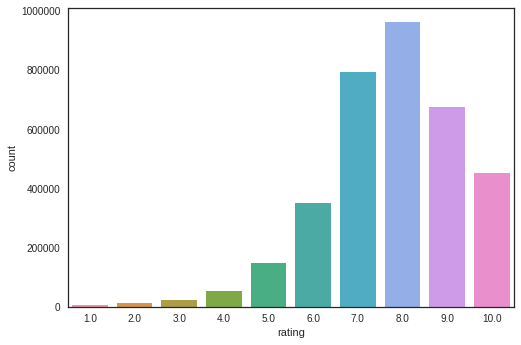

In [0]:
sns.set_context('notebook')
sns.countplot(x='rating',data=df)

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


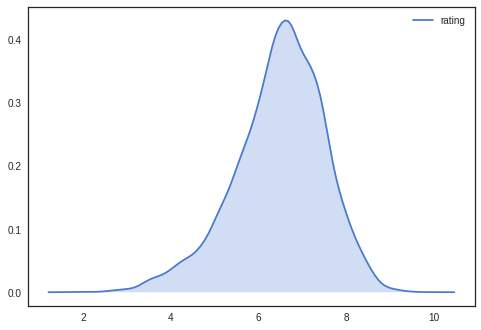

In [0]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
sns.set(style="white", palette="muted", color_codes=True)
sns.kdeplot(anime.rating, shade=True,color="b")


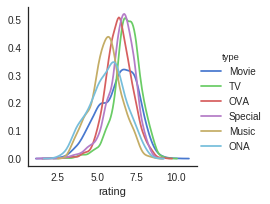

In [0]:

grid = sns.FacetGrid(anime, hue="type")
grid.map(sns.kdeplot, 'rating')
grid.add_legend()

plt.show()


#Modeling

##Data preparing

###Slicing bench mark
*Remove animation with too few reviews (they are relatively not popular)

*Remove user who give too lfew reviews (they are relatively less active)

In [0]:
f = ['count','mean']

df_anime_summary = df.groupby('anime_id')['rating'].agg(f)
df_anime_summary.index = df_anime_summary.index.map(int)
anime_benchmark = round(df_anime_summary['count'].quantile(0.8),0)
drop_anime_list = df_anime_summary[df_anime_summary['count'] < anime_benchmark].index

print('Anime minimum times of review: {}'.format(anime_benchmark))


Anime minimum times of review: 614.0


In [0]:
df_user_summary = df.groupby('user_id')['rating'].agg(f)
df_user_summary.index = df_user_summary.index.map(int)
user_benchmark = round(df_user_summary['count'].quantile(0.8),0)
drop_user_list = df_user_summary[df_user_summary['count'] < user_benchmark].index

print('User minimum times of review: {}'.format(user_benchmark))

User minimum times of review: 140.0


In [0]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['anime_id'].isin(drop_anime_list)]
df = df[~df['user_id'].isin(drop_user_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::500000, :])

Original Shape: (6337241, 3)
After Trim Shape: (3479222, 3)
-Data Examples-
         user_id  anime_id  rating
302            5         6     8.0
1137289    10903       401    10.0
2273100    21893      5355     8.0
3312509    30548     12113    10.0
4488658    42533     15377     6.0
5619236    52763       918    10.0
6672962    61547     14829     6.0


###pivot dataframe

In [0]:
df_p = pd.pivot_table(df,values='rating',index='user_id',columns='anime_id')

print(df_p.shape)

(14039, 1987)


##Recommendation model - Collaborative Filtering SVD

In [0]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['user_id', 'anime_id', 'rating']], reader)
data.split(n_folds=3)

svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

/usr/local/lib/python3.6/dist-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/usr/local/lib/python3.6/dist-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 3.1519
MAE:  2.8540
------------
Fold 2
RMSE: 3.1528
MAE:  2.8555
------------
Fold 3
RMSE: 3.1534
MAE:  2.8564
------------
------------
Mean RMSE: 3.1527
Mean MAE : 2.8553
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [2.853981654900793,
                             2.8554798045646415,
                             2.8564113508188758],
                            'rmse': [3.1518731657587296,
                             3.1527896290197117,
                             3.1534214991446143]})

#### show part of one user's ratings history

In [0]:
anime.set_index('anime_id', inplace = True)

In [0]:
anime.head()

,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [0]:
anime_name = anime['name']
df_23456 = df[(df['user_id'] == 23456 ) & (df['rating'] == 8.0)]
df_23456  = df_23456 .set_index('anime_id')
df_23456  = df_23456 .join(anime_name)
print(df_23456 )

          user_id  rating                                               name
anime_id                                                                    
5           23456     8.0                    Cowboy Bebop: Tengoku no Tobira
43          23456     8.0                                 Ghost in the Shell
51          23456     8.0                                   Tenshi Kinryouku
59          23456     8.0                                            Chobits
71          23456     8.0                                  Full Metal Panic!
90          23456     8.0                            Mobile Suit Gundam Wing
134         23456     8.0                                    Gunslinger Girl
154         23456     8.0                                        Shaman King
199         23456     8.0                      Sen to Chihiro no Kamikakushi
223         23456     8.0                                        Dragon Ball
270         23456     8.0                                           Hellsing

#Recommendation with SVD

In [0]:
user_23456 = anime.copy()
user_23456 = user_23456.reset_index()
user_23456 = user_23456[~user_23456['anime_id'].isin(drop_anime_list)]

# getting full dataset
data = Dataset.load_from_df(df[['user_id', 'anime_id', 'rating']], reader)

trainset = data.build_full_trainset()
svd.train(trainset)

user_23456['Estimate_Score'] = user_23456['anime_id'].apply(lambda x: svd.predict(23456, x).est)

user_23456 = user_23456.drop( 'anime_id', axis = 1)

user_23456 = user_23456.sort_values('Estimate_Score', ascending=False)


/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


In [0]:
print(user_23456.head(10))

                                                  name  \
0                                       Kimi no Na wa.   
9196     Kero Kero Keroppi no Tomodachi wa Mahoutsukai   
9204                    Kibun wa Uaa Jitsuzai OL Kouza   
9203                                Ki-Fighter Taerang   
9200                                     Keshikasu-kun   
9199    Kero Kero Keroppi: Hasunoue Town Kiki Ippatsu!   
9198  Kero Kero Keroppi no Yowamushi-ouji no Daibouken   
9197           Kero Kero Keroppi no Tomodachitte Ii na   
9195        Kero Kero Keroppi no Tomodachi ni Narou yo   
9726         Niji no Kanata e! Shoujo Diana Monogatari   

                                     genre     type episodes  rating  members  \
0     Drama, Romance, School, Supernatural    Movie        1    9.37   200630   
9196                           Kids, Magic      OVA        1    5.73       71   
9204                        Comedy, Seinen      OVA        1    5.83       51   
9203                       Adventure,

In [0]:
df_23456all = df[df['user_id'] == 23456 ]
df_23456all.head()

,user_id,anime_id,rating
2460964,23456,1,9.0
2460965,23456,5,8.0
2460966,23456,16,10.0
2460967,23456,30,10.0
2460968,23456,33,9.0


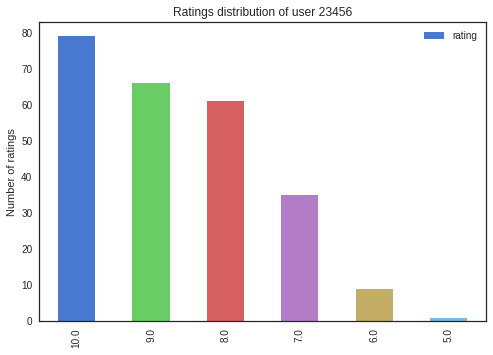

In [0]:
df_23456all.rating.value_counts().plot(kind="bar")
plt.ylabel(u"Number of ratings")
plt.title(u"Ratings distribution of user 23456")

plt.legend()

#Recommend with Pearsons' R correlations

In [0]:
def recommend(anime_title, min_count):
    print("For anime ({})".format(anime_title))
    print("- Top 10 anime recommended based on Pearsons'R correlation - ")
    i = int(anime.index[anime['name'] == anime_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(anime).join(df_anime_summary)[['PearsonR', 'name', 'count', 'mean', 'genre','type','episodes','rating']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [0]:
recommend("Gintama", 0)

For anime (Gintama)
- Top 10 anime recommended based on Pearsons'R correlation - 
PearsonR                                               name  count      mean                                              genre     type episodes  rating
                                                                                                                                                         
1.000000                                            Gintama   4264  9.236398  Action, Comedy, Historical, Parody, Samurai, S...       TV      201    9.04
0.823223                                      Gintama&#039;   3115  9.272552  Action, Comedy, Historical, Parody, Samurai, S...       TV       51    9.16
0.669844                           Gintama&#039;: Enchousen   2126  9.202258  Action, Comedy, Historical, Parody, Samurai, S...       TV       13    9.11
0.592805                                           Gintama°   1188  9.449495  Action, Comedy, Historical, Parody, Samurai, S...       TV       51   